In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from geopy.distance import geodesic
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
import math
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.layers.experimental.preprocessing import Normalization

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/elsamaulida5/machine-learning/main/cleaned%20data/laundry.csv')

In [3]:
data.isna().sum()

ID Laundry           0
Name                 0
Fulladdress          2
Categories           0
phone              131
Review Count         0
Average Rating       0
Review URL          24
Google Maps URL      0
Latitude             0
Longitude            0
Website            760
Opening Hours      102
Featured Image       8
Layanan              3
dtype: int64

In [4]:
data = data.fillna('None')
data.isna().sum()

ID Laundry         0
Name               0
Fulladdress        0
Categories         0
phone              0
Review Count       0
Average Rating     0
Review URL         0
Google Maps URL    0
Latitude           0
Longitude          0
Website            0
Opening Hours      0
Featured Image     0
Layanan            0
dtype: int64

In [5]:
data['Layanan'].unique()

array(['just wash, dry cleaning, iron wash', 'just wash, iron wash',
       'just wash, dry cleaning, iron wash, self laundry', 'None',
       'just wash, dry cleaning, iron wash, carpet laundry',
       'just wash, dry cleaning, iron wash, shoe laundry',
       'just wash, iron wash, self laundry',
       'just wash, dry cleaning, shoe laundry, iron wash, carpet laundry',
       'just wash, car seat laundry, iron wash',
       'just wash, dry cleaning, car seat laundry, iron wash',
       'self laundry'], dtype=object)

In [6]:
# Kata kunci untuk self-service
keyword = 'self laundry'

# Memfilter laundry yang termasuk self-service berdasarkan kata kunci
self_service_df = data[data['Layanan'].str.contains(keyword, case=False, na=False)]

# Menampilkan hasil
#print("Data yang memiliki layanan self-service:")
#self_service_df

#### Model Self Service (Tensorflow)

In [7]:
def prepare_data(self_service_df, user_location):
    # Menambahkan fitur jarak ke lokasi pengguna
    self_service_df['Distance'] = self_service_df.apply(lambda row: geodesic(user_location, (row['Latitude'], row['Longitude'])).km, axis=1)

    # Membuat fitur dan label dengan fitur jarak
    features = self_service_df[['Latitude', 'Longitude', 'Distance']]
    labels = self_service_df['Average Rating']

    # Split data menjadi train dan test
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Normalisasi fitur
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

In [8]:
def build_model():
    # Input layer
    latitude_input = Input(shape=(1,), name='latitude')
    longitude_input = Input(shape=(1,), name='longitude')
    distance_input = Input(shape=(1,), name='distance')

    # Menggabungkan input
    concatenated = Concatenate()([latitude_input, longitude_input, distance_input])

    # Normalize the concatenated inputs
    normalizer = Normalization()
    normalizer.adapt(np.array([[0, 0, 0], [1, 1, 1]]))  # Dummy data to adapt normalizer
    normalized = normalizer(concatenated)

    # Membangun model neural network
    x = Dense(64, activation='relu')(normalized)
    x = Dropout(0.2)(x)  # Add dropout to prevent overfitting
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)  # Add dropout to prevent overfitting
    output = Dense(1, activation='linear')(x)

    # Model
    model = Model(inputs=[latitude_input, longitude_input, distance_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')  # Use MSE as the loss function

    return model

def train_model(model, X_train_scaled, X_test_scaled, y_train, y_test):
    # Membuat dataset TensorFlow dengan dua input terpisah
    def split_lat_lon_distance(features, label):
        latitude = features[0]
        longitude = features[1]
        distance = features[2]
        return {'latitude': latitude, 'longitude': longitude, 'distance': distance}, label

    # Membuat dataset dengan map function untuk memisahkan latitude dan longitude
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train.values))
    train_dataset = train_dataset.shuffle(buffer_size=len(X_train_scaled)).map(split_lat_lon_distance).batch(32)

    test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test.values))
    test_dataset = test_dataset.map(split_lat_lon_distance).batch(32)

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

    # Melatih model
    history = model.fit(train_dataset, epochs=100, validation_data=test_dataset, callbacks=[early_stopping, reduce_lr])

    # Evaluasi model
    loss = model.evaluate(test_dataset)
    print("Test Loss:", loss)

    # Prediksi
    y_pred = model.predict(test_dataset).flatten()  # Pastikan bentuknya sesuai
    # Menghitung metrik tambahan
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Absolute Error:", mae)
    print("Mean Squared Error:", mse)

    return history

In [9]:
def save_model(model, filename):
    model.save(filename)

def main(self_service_df, user_location):
    X_train_scaled, X_test_scaled, y_train, y_test = prepare_data(self_service_df, user_location)
    model = build_model()
    history = train_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
    save_model(model, "model_SelfService.h5")
    return model, history

user_location = np.array([-6.918552, 107.586449])
model, history = main(self_service_df, user_location)

<ipython-input-7-a55f6d13727a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self_service_df['Distance'] = self_service_df.apply(lambda row: geodesic(user_location, (row['Latitude'], row['Longitude'])).km, axis=1)


Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 17.5562 - val_loss: 20.9538 - lr: 0.0010
Epoch 2/100
1/1 [==============================] - 0s 57ms/step - loss: 16.7739 - val_loss: 20.4260 - lr: 0.0010
Epoch 3/100
1/1 [==============================] - 0s 43ms/step - loss: 16.0568 - val_loss: 19.9176 - lr: 0.0010
Epoch 4/100
1/1 [==============================] - 0s 39ms/step - loss: 16.2993 - val_loss: 19.4221 - lr: 0.0010
Epoch 5/100
1/1 [==============================] - 0s 41ms/step - loss: 15.7209 - val_loss: 18.9337 - lr: 0.0010
Epoch 6/100
1/1 [==============================] - 0s 39ms/step - loss: 15.0402 - val_loss: 18.4524 - lr: 0.0010
Epoch 7/100
1/1 [==============================] - 0s 39ms/step - loss: 14.7809 - val_loss: 17.9807 - lr: 0.0010
Epoch 8/100
1/1 [==============================] - 0s 42ms/step - loss: 15.4084 - val_loss: 17.5230 - lr: 0.0010
Epoch 9/100
1/1 [==============================] - 0s 39ms/step - loss: 14.5171 - val_loss: 17.071

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


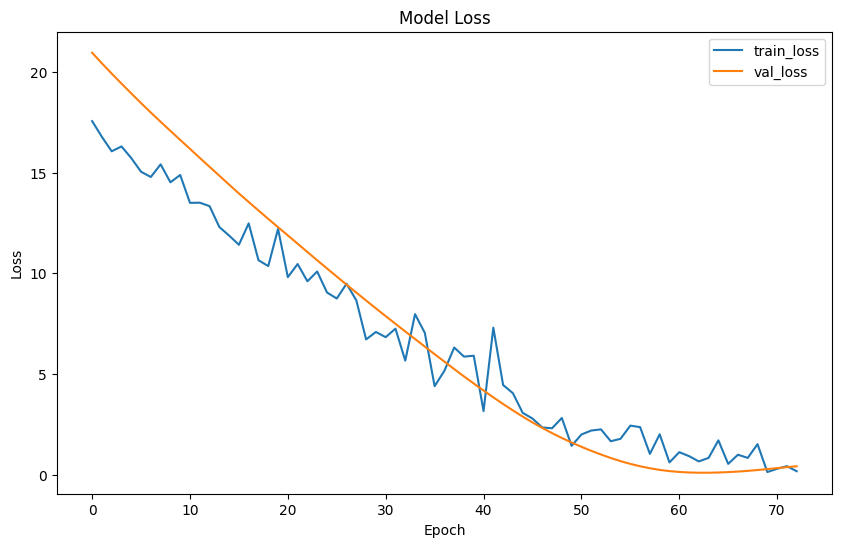

In [10]:
# Load the saved model
model = load_model("model_SelfService.h5")

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [11]:
# Menjalankan Model_SelfService.h5
# Fungsi Haversine
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    r = 6371
    return c * r

def find_nearest_places(self_service_df, user_location, model_path):
    model = load_model(model_path)

    # Menghitung jarak dari lokasi pengguna ke setiap tempat
    self_service_df.loc[:, 'Distance'] = self_service_df.apply(lambda row: haversine(user_location[1], user_location[0], row['Longitude'], row['Latitude']), axis=1)

    # Menyusun tempat berdasarkan prediksi rating dan jarak
    recommended_places = self_service_df.sort_values(by=['Distance'], ascending=[True])

    # Membatasi hasil menjadi 10 tempat terdekat
    top_10_places = recommended_places.head(10)

    return top_10_places

def print_nearest_places(nearest_places, user_location):
    selected_columns = ['Name', 'Fulladdress', 'Categories', 'phone', 'Average Rating', 'Distance', 'Google Maps URL','Website', 'Opening Hours', 'Layanan']

    # Filter tempat yang berada dalam jarak 500 km
    nearest_places_within_50km = nearest_places[nearest_places['Distance'] <= 50]

    if nearest_places_within_50km.empty:
        print("Tidak ada tempat laundry yang ditemukan")
        return

    print(nearest_places)

# Contoh penggunaan fungsi
user_location = np.array([-6.918552, 107.586449])
nearest_places_sorted = find_nearest_places(self_service_df, user_location, "model_SelfService.h5")
print_nearest_places(nearest_places_sorted, user_location)

      ID Laundry                              Name  \
16            17            Pusat Laundry Nasional   
163          164  Green.Point Laundry Antar jemput   
110          111         Cleanlite Laundry Bandung   
101          102                   Laundry Sendiri   
147          148                   Humaira Laundry   
691          692                 Freshclin Laundry   
704          705                      Bong Laundry   
964          965                    Adeeva Laundry   
1097        1098                    Bamb's Laundry   

                                            Fulladdress  \
16    Jl. Pasirkoja No.12, Nyengseret, Kec. Astanaan...   
163   Jl. Sekeloa No.30a, Lebakgede, Kecamatan Coblo...   
110   Jl. Cibeunying Kolot No.26, Cigadung, Kec. Cib...   
101   Jl. Margasari No.28, Margasari, Kec. Buahbatu,...   
147   3M5V+64H, Jl. Gedebage Wetan, Cisaranten Kidul...   
691   Deretan BCA, sblh Indomaret ps. Tb Barat, Jl. ...   
704   Jl. Taman Palem Lestari Blk. C1 No.22, C